# Introduction to IBKR API:

https://www.interactivebrokers.com/campus/ibkr-api-page/twsapi-doc/#tws-download

In [1]:
# Here are the imports that we will need throughout the all notebook

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import threading
import asyncio
import scipy

from ib_insync import *

from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ib_insync import IB, Stock, util
from ib_insync import Future
from ib_insync import Stock
from ib_insync import Option
from ib_insync import Bond
from ib_insync import Forex
# Fondamental
import xml.etree.ElementTree as ET

In [5]:
ib = IB()
util.startLoop()
await ib.connectAsync('127.0.0.1', 7496, clientId=3) # Don't forget to change the client ID

<IB connected to 127.0.0.1:7496 clientId=3>

# Spot OVHLC:

In [6]:
def ibkr_download(
    ib,
    ticker: str,
    start: str,
    end: str,
    interval: str = "15 mins",
    exchange: str = "SMART",
    currency: str = "EUR",
    primaryExchange: str = "SBF",
    chunk: str = "1 Y",
    useRTH: bool = False,
    sleep_s: float = 0.6
) -> pd.DataFrame:
    """
    Simple wrapper style yfinance, mais IBKR.
    - ib : instance IB déjà connectée
    - start/end : 'YYYY-MM-DD'
    - interval : ex '15 mins'
    """

    def to_naive(ts: pd.Timestamp) -> pd.Timestamp:
        ts = pd.to_datetime(ts)
        if getattr(ts, "tzinfo", None) is not None:
            ts = ts.tz_localize(None)
        return ts

    start_dt = to_naive(start)
    end_dt   = to_naive(end)

    contract = Stock(ticker, exchange, currency, primaryExchange=primaryExchange)
    ib.qualifyContracts(contract)

    dfs = []
    current_end = end_dt

    while current_end > start_dt:
        bars = ib.reqHistoricalData(
            contract,
            endDateTime=current_end.strftime("%Y%m%d %H:%M:%S"),
            durationStr=chunk,            # "1 Y" (si pacing: "6 M")
            barSizeSetting=interval,      # "15 mins"
            whatToShow="TRADES",
            useRTH=useRTH,
            formatDate=1
        )

        if not bars:
            break

        df = util.df(bars).rename(columns={"date": "Datetime"})
        df["Datetime"] = pd.to_datetime(df["Datetime"])

        # IMPORTANT: rendre tz-naive si IB renvoie une timezone
        if hasattr(df["Datetime"].dt, "tz") and df["Datetime"].dt.tz is not None:
            df["Datetime"] = df["Datetime"].dt.tz_localize(None)

        dfs.append(df)

        current_end = df["Datetime"].min()
        ib.sleep(sleep_s)

    if not dfs:
        return pd.DataFrame()

    out = (pd.concat(dfs, ignore_index=True)
             .drop_duplicates(subset=["Datetime"])
             .sort_values("Datetime")
             .reset_index(drop=True))

    return out[(out["Datetime"] >= start_dt) & (out["Datetime"] <= end_dt)]

In [12]:
df = ibkr_download(
    ib,
    ticker="GLE",
    start="2020-01-01",
    end="2025-01-01",
    interval="1 day"
)


# 1 secs, 5 secs, 10 secs, 15 secs, 30 secs, 1 min, 2 mins, 3 mins, 4 mins, 5 mins, 10 mins, 15 mins, 20 mins, 30 mins, 1 hour, 2 hours, 3 hours, 4 hours, 8 hours, 1 day, 1W, 1M sont les durées acceptées par IBKR

In [13]:
df

,Datetime,open,high,low,close,volume,average,barCount
1,2020-01-02,30.816,32.006,30.814,31.656,4311860.0,31.6530,19969
2,2020-01-03,31.480,31.480,31.100,31.336,3900498.0,31.2618,17812
3,2020-01-06,31.214,31.380,30.500,31.080,4528722.0,30.8586,21214
4,2020-01-07,31.396,31.546,31.120,31.460,4280283.0,31.3828,19220
5,2020-01-08,31.196,31.900,31.100,31.770,4407052.0,31.5920,23259
...,...,...,...,...,...,...,...,...
1279,2024-12-23,26.685,26.870,26.420,26.620,1859510.0,26.5805,9826
1280,2024-12-24,26.700,26.850,26.490,26.500,748068.0,26.6230,4258
1281,2024-12-27,26.485,26.980,26.400,26.780,2451956.0,26.8000,13132
1282,2024-12-30,26.645,27.080,26.640,26.880,1788417.0,26.9135,9854


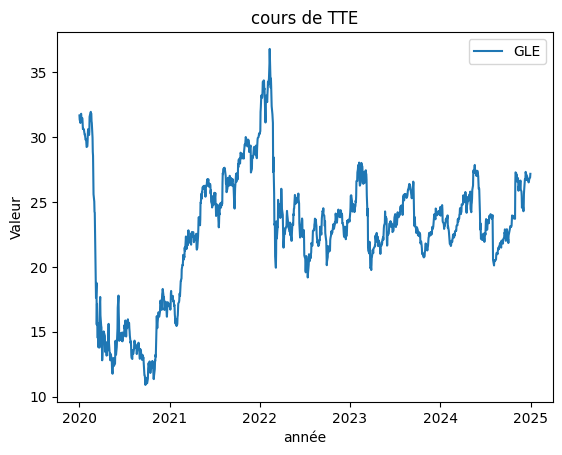

In [15]:
plt.plot(df["Datetime"], df["close"], label="GLE")
plt.legend()
plt.title("cours de TTE")
plt.xlabel("année")
plt.ylabel("Valeur")
plt.show()

# Futures:

In [16]:
CANDIDATES = [

    ("CL",   "NYMEX",  "USD"),   # WTI Crude Oil
    ("GC",   "COMEX",  "USD"),   # Gold
    ("6E",   "CME",    "USD"),   # EUR/USD future
    ("FDAX", "EUREX",  "EUR"),   # DAX future
    ("FESX", "EUREX",  "EUR"),   # Euro Stoxx 50 future
]

async def find_any_future_contracts(ib, n_show=10):
    for sym, ex, ccy in CANDIDATES:
        c = Future(sym, exchange=ex, currency=ccy)
        details = await ib.reqContractDetailsAsync(c)

        if details and len(details) > 0:
            print(f"OK -> {sym} @ {ex} ({ccy}) | Nb contrats: {len(details)}")
            for d in details[:n_show]:
                cd = d.contract
                print(cd.localSymbol, cd.lastTradeDateOrContractMonth, cd.multiplier)
            return details  # renvoie les détails du premier marché qui marche

        print(f"KO -> {sym} @ {ex} ({ccy}) | Nb contrats: 0")

    return []

details = await find_any_future_contracts(ib, n_show=10)


OK -> CL @ NYMEX (USD) | Nb contrats: 133
CLG6 20260120 1000
CLM6 20260519 1000
CLZ6 20261120 1000
CLF7 20261221 1000
CLG7 20270120 1000
CLH6 20260220 1000
CLJ6 20260320 1000
CLK6 20260421 1000
CLN6 20260622 1000
CLQ6 20260721 1000


In [18]:
details_sorted = sorted(details, key=lambda d: d.contract.lastTradeDateOrContractMonth)

front = details_sorted[0].contract
print("Front month:", front.localSymbol, front.lastTradeDateOrContractMonth, "mult:", front.multiplier)

await ib.qualifyContractsAsync(front)

Front month: CLG6 20260120 mult: 1000


[Contract(secType='FUT', conId=304037410, symbol='CL', lastTradeDateOrContractMonth='20260120', multiplier='1000', exchange='NYMEX', currency='USD', localSymbol='CLG6', tradingClass='CL')]

In [20]:
bars = await ib.reqHistoricalDataAsync(
    front,
    endDateTime="",
    durationStr="1 Y",
    barSizeSetting="1 day",
    whatToShow="TRADES",
    useRTH=False,
    formatDate=1
)

df_es = util.df(bars).rename(columns={"date": "Datetime"})
df_es["Datetime"] = pd.to_datetime(df_es["Datetime"])
df_es


,Datetime,open,high,low,close,volume,average,barCount
0,2024-12-27,66.71,66.71,66.71,66.71,0.0,66.710,0
1,2024-12-30,67.09,67.09,67.02,67.02,2.0,67.090,2
2,2024-12-31,67.60,67.60,67.60,67.60,0.0,67.600,0
3,2025-01-02,68.00,68.73,68.00,68.30,52.0,68.268,41
4,2025-01-03,68.76,68.76,68.69,68.69,25.0,68.750,17
...,...,...,...,...,...,...,...,...
248,2025-12-19,55.90,56.72,55.61,56.52,131684.0,56.286,58458
249,2025-12-22,56.63,58.13,56.60,58.01,137292.0,57.665,62331
250,2025-12-23,57.95,58.56,57.74,58.38,97430.0,58.094,43772
251,2025-12-24,58.47,58.75,58.13,58.35,64502.0,58.470,33977


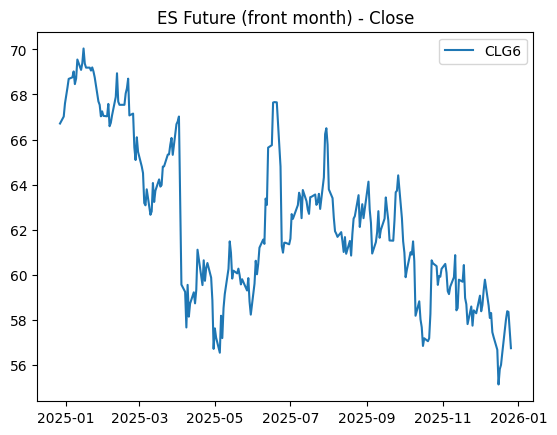

In [21]:
plt.plot(df_es["Datetime"], df_es["close"], label=front.localSymbol)
plt.legend()
plt.title("ES Future (front month) - Close")
plt.show()

In [22]:
async def ibkr_list_futures_expiries(
    ib,
    root: str,
    exchange: str,
    currency: str,
    n: int | None = None
) -> pd.DataFrame:
    """
    Retourne toutes les échéances futures à venir pour un sous-jacent future (root symbol).
    Exemple: root="ES", exchange="CME", currency="USD".
    
    - n: optionnel, limite le nombre d'échéances renvoyées (après tri).
    """

    c = Future(root, exchange=exchange, currency=currency)
    details = await ib.reqContractDetailsAsync(c)

    rows = []
    for d in details:
        cd = d.contract
        rows.append({
            "root": root,
            "exchange": exchange,
            "currency": currency,
            "localSymbol": cd.localSymbol,
            "lastTradeDateOrContractMonth": cd.lastTradeDateOrContractMonth,
            "multiplier": cd.multiplier,
            "conId": cd.conId
        })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    s = df["lastTradeDateOrContractMonth"].astype(str)
    fmt = s.str.len().map({6: "%Y%m", 8: "%Y%m%d"}).fillna("%Y%m%d")

    parsed = []
    for val, f in zip(s, fmt):
        parsed.append(pd.to_datetime(val, format=f, errors="coerce"))
    df["expiry"] = parsed


    now = pd.Timestamp.utcnow().tz_localize(None)
    df = df[df["expiry"].notna() & (df["expiry"] >= now)].copy()

    df = df.sort_values("expiry").reset_index(drop=True)
    if n is not None:
        df = df.head(n).reset_index(drop=True)

    return df


In [23]:
df_exp = await ibkr_list_futures_expiries(
    ib,
    root="ES",
    exchange="CME",
    currency="USD"
)

df_exp


,root,exchange,currency,localSymbol,lastTradeDateOrContractMonth,multiplier,conId,expiry
0,ES,CME,USD,ESH6,20260320,50,649180695,2026-03-20
1,ES,CME,USD,ESM6,20260618,50,649180678,2026-06-18
2,ES,CME,USD,ESU6,20260918,50,649180671,2026-09-18
3,ES,CME,USD,ESZ6,20261218,50,515416632,2026-12-18
4,ES,CME,USD,ESH7,20270319,50,649180684,2027-03-19
5,ES,CME,USD,ESM7,20270617,50,649180661,2027-06-17
6,ES,CME,USD,ESU7,20270917,50,649180681,2027-09-17
7,ES,CME,USD,ESZ7,20271217,50,586139767,2027-12-17
8,ES,CME,USD,ESH8,20280317,50,649180666,2028-03-17
9,ES,CME,USD,ESM8,20280616,50,649180690,2028-06-16


In [24]:
contract = Stock("TTE", "SMART", "EUR", primaryExchange="SBF")
await ib.qualifyContractsAsync(contract)

params = await ib.reqSecDefOptParamsAsync(
    contract.symbol,
    "",
    contract.secType,
    contract.conId
)

params

[OptionChain(exchange='EUREX', underlyingConId='29612193', tradingClass='TOTB', multiplier='100', expirations=['20260102', '20260109', '20260116', '20260123', '20260130', '20260220', '20260320', '20260619', '20260918', '20261218', '20270618', '20271217', '20280616', '20281215', '20291221', '20301220'], strikes=[0.01, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0, 46.5, 47.0, 47.5, 48.0, 48.5, 49.0, 49.5, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 70.0, 72.0, 76.0, 80.0, 84.0, 88.0, 92.0, 96.0, 100.0, 120.0, 140.0]),
 OptionChain(exchange='MONEP', underlyingConId='29612193', tradingClass='TO9C', multiplier='100', expirations=['20260116', '20260220', '20260320', '20260619', '20260918', '20261218', '20270618', '20271217'], strikes=[30.0, 40.0, 45.0, 48.0, 50.0, 52.0, 54.0, 55.0, 56.0, 58.0, 60.0, 80.0]),
 OptionChain(exchan

In [25]:
p = params[0]
print("exchange:", p.exchange)
print("tradingClass:", p.tradingClass)
print("expirations:", list(p.expirations)[:5])


rows = []
for k in strikes:
    for right in ["C", "P"]:
        opt = Option(
            symbol=contract.symbol,
            lastTradeDateOrContractMonth=expiry,
            strike=k,
            right=right,
            exchange=p.exchange,
            currency=contract.currency
        )
        rows.append(opt)

len(rows)

exchange: EUREX
tradingClass: TOTB
expirations: ['20260102', '20260109', '20260116', '20260123', '20260130']


NameError: name 'strikes' is not defined

In [56]:
rows

[Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=0.01, right='C', exchange='EUREX', currency='EUR'),
 Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=0.01, right='P', exchange='EUREX', currency='EUR'),
 Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=12.0, right='C', exchange='EUREX', currency='EUR'),
 Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=12.0, right='P', exchange='EUREX', currency='EUR'),
 Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=14.0, right='C', exchange='EUREX', currency='EUR'),
 Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=14.0, right='P', exchange='EUREX', currency='EUR'),
 Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=16.0, right='C', exchange='EUREX', currency='EUR'),
 Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=16.0, right='P', exchange='EUREX', currency='EUR'),
 Option(symbol='TTE', la

In [61]:
import pandas as pd
from ib_insync import Option, util

async def ibkr_option_history(
    ib,
    symbol: str,
    expiry: str,
    strike: float,
    right: str,                # "C" ou "P"
    tradingClass: str,         # OBLIGATOIRE
    currency: str = "EUR",
    duration: str = "1 Y",
    barSize: str = "1 day",
    useRTH: bool = False
) -> pd.DataFrame:

    opt = Option(
        symbol=symbol,
        lastTradeDateOrContractMonth=expiry,
        strike=strike,
        right=right,
        exchange="SMART",        # ⚠️ PAS EUREX
        currency=currency,
        tradingClass=tradingClass
    )

    await ib.qualifyContractsAsync(opt)

    bars = await ib.reqHistoricalDataAsync(
        opt,
        endDateTime="",
        durationStr=duration,
        barSizeSetting=barSize,
        whatToShow="TRADES",
        useRTH=useRTH,
        formatDate=1
    )

    if not bars:
        return pd.DataFrame()

    df = util.df(bars).rename(columns={"date": "Datetime"})
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    df["symbol"] = symbol
    df["expiry"] = expiry
    df["strike"] = strike
    df["right"] = right

    return df


In [64]:
df_opt_hist = await ibkr_option_history(
    ib,
    symbol="TTE",
    expiry="20260102",
    strike=40.0,
    right="C",
    tradingClass=p.tradingClass,   # ← ICI
    duration="1 Y"
)

df_opt_hist.head()


Unknown contract: Option(symbol='TTE', lastTradeDateOrContractMonth='20260102', strike=40.0, right='C', exchange='SMART', currency='EUR', tradingClass='TOTB')


""


In [66]:
details = await ib.reqContractDetailsAsync(contract)
d = details[0]
print(d.contract.conId, d.longName, d.minTick, d.contract.multiplier)
print(d.tradingHours)


29612193 TOTALENERGIES SE 0.0001 
20251228:CLOSED;20251229:0730-20251229:2300;20251230:0730-20251230:1740;20251231:0800-20251231:1405;20260101:CLOSED;20260102:0730-20260102:2300


# Fondamentale:

In [67]:
stk = Stock("TTE", "SMART", "EUR", primaryExchange="SBF")
await ib.qualifyContractsAsync(stk)

[Stock(conId=29612193, symbol='TTE', exchange='SMART', primaryExchange='SBF', currency='EUR', localSymbol='TTE', tradingClass='TTE')]

In [68]:
xml = await ib.reqFundamentalDataAsync(
    stk,
    reportType="CompanyOverview"
)

print(xml[:500])  # preview

[]


In [72]:
print(xml)
print(type(xml))


[]
<class 'list'>


# Fixed income:

In [26]:
bond = Bond(
    symbol="US",
    exchange="SMART",
    currency="USD"
)

details = await ib.reqContractDetailsAsync(bond)
print(len(details))


14


In [27]:
async def ibkr_list_fr_rate_futures(
    ib,
    include_past: bool = False,
    max_expiries: int | None = None
) -> pd.DataFrame:
    """
    Liste les contrats futures de taux liés à la France (OAT future) disponibles sur IBKR.
    Retourne un DataFrame avec localSymbol, expiry, conId, multiplier, tradingClass, etc.
    """

    # France: Euro-OAT (sur EUREX). Trading class souvent FOAT (info IBKR), mais on liste via ContractDetails.
    root, exchange, currency = "OAT", "EUREX", "EUR"

    base = Future(root, exchange=exchange, currency=currency)
    details = await ib.reqContractDetailsAsync(base)

    rows = []
    now = pd.Timestamp.utcnow().tz_localize(None)

    for d in details:
        c = d.contract
        exp_raw = str(c.lastTradeDateOrContractMonth)

        # parse YYYYMMDD ou YYYYMM
        expiry = pd.to_datetime(exp_raw, format="%Y%m%d", errors="coerce")
        if pd.isna(expiry):
            expiry = pd.to_datetime(exp_raw, format="%Y%m", errors="coerce")

        if (not include_past) and pd.notna(expiry) and (expiry < now):
            continue

        rows.append({
            "country": "FR",
            "root": root,
            "exchange": exchange,
            "currency": currency,
            "localSymbol": getattr(c, "localSymbol", None),
            "expiry_raw": exp_raw,
            "expiry": expiry,
            "conId": c.conId,
            "multiplier": getattr(c, "multiplier", None),
            "tradingClass": getattr(c, "tradingClass", None),
            "longName": getattr(d, "longName", None),
        })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df = df.sort_values("expiry", na_position="last").reset_index(drop=True)

    if max_expiries is not None:
        df = df.head(max_expiries).reset_index(drop=True)

    return df


In [28]:
df_fr = await ibkr_list_fr_rate_futures(ib, include_past=False, max_expiries=20)
df_fr


,country,root,exchange,currency,localSymbol,expiry_raw,expiry,conId,multiplier,tradingClass,longName
0,FR,OAT,EUREX,EUR,FOAT 20260306 M,20260306,2026-03-06,790309221,1000,FOAT,Euro-OAT French Government Bond
1,FR,OAT,EUREX,EUR,FOAT 20260608 M,20260608,2026-06-08,813041732,1000,FOAT,Euro-OAT French Government Bond
2,FR,OAT,EUREX,EUR,FOAT 20260908 M,20260908,2026-09-08,837651146,1000,FOAT,Euro-OAT French Government Bond


In [29]:
US_RATE_FUTURES = [
    ("1Y",  "ZT", "CBOT", "USD"),
    ("5Y",  "ZF", "CBOT", "USD"),
    ("10Y", "ZN", "CBOT", "USD"),
    ("20Y", "UB", "CBOT", "USD"),
    ("30Y", "ZB", "CBOT", "USD"),
]

async def ibkr_us_rate_futures_front_contracts(ib) -> pd.DataFrame:
    rows = []

    for tenor, root, exch, ccy in US_RATE_FUTURES:
        base = Future(root, exchange=exch, currency=ccy)
        details = await ib.reqContractDetailsAsync(base)

        if not details:
            rows.append({
                "tenor": tenor,
                "root": root,
                "status": "NO_CONTRACTS"
            })
            continue

        details_sorted = sorted(
            details,
            key=lambda d: d.contract.lastTradeDateOrContractMonth
        )
        c = details_sorted[0].contract

        rows.append({
            "tenor": tenor,
            "root": root,
            "exchange": exch,
            "currency": ccy,
            "localSymbol": c.localSymbol,
            "expiry": c.lastTradeDateOrContractMonth,
            "conId": c.conId,
            "multiplier": c.multiplier,
            "tradingClass": c.tradingClass,
            "status": "OK"
        })

    return pd.DataFrame(rows)


In [30]:
df_us_curve = await ibkr_us_rate_futures_front_contracts(ib)
df_us_curve


,tenor,root,exchange,currency,localSymbol,expiry,conId,multiplier,tradingClass,status
0,1Y,ZT,CBOT,USD,ZTZ5,20251231,772678700,2000,ZT,OK
1,5Y,ZF,CBOT,USD,ZFZ5,20251231,772678694,1000,ZF,OK
2,10Y,ZN,CBOT,USD,ZNH6,20260320,792996527,1000,ZN,OK
3,20Y,UB,CBOT,USD,UBH6,20260320,792996517,1000,UB,OK
4,30Y,ZB,CBOT,USD,ZBH6,20260320,792996522,1000,ZB,OK


nécéssite abonnement IBKR US Futures (à vérifier)

In [31]:
from ib_insync import Forex, util
import pandas as pd

def ibkr_fx_history(ib, pair="EURUSD", duration="5 Y", bar_size="1 day"):
    contract = Forex(pair)  # <-- un seul argument
    ib.qualifyContracts(contract)

    bars = ib.reqHistoricalData(
        contract,
        endDateTime="",
        durationStr=duration,
        barSizeSetting=bar_size,
        whatToShow="MIDPOINT",
        useRTH=False,
        formatDate=1
    )
    df = util.df(bars).rename(columns={"date": "Datetime"})
    df["Datetime"] = pd.to_datetime(df["Datetime"])
    return df


In [32]:
df_eurusd = ibkr_fx_history(
    ib,
    duration="5 Y",
    bar_size="1 day"
)

df_eurusd

,Datetime,open,high,low,close,volume,average,barCount
0,2020-12-28,1.219125,1.225070,1.218110,1.221670,-1.0,-1.0,-1
1,2020-12-29,1.220855,1.227520,1.220770,1.225040,-1.0,-1.0,-1
2,2020-12-30,1.224950,1.231035,1.224925,1.229915,-1.0,-1.0,-1
3,2020-12-31,1.229575,1.230945,1.220915,1.221600,-1.0,-1.0,-1
4,2021-01-04,1.223325,1.230960,1.222825,1.224730,-1.0,-1.0,-1
...,...,...,...,...,...,...,...,...
1293,2025-12-19,1.172190,1.173785,1.170255,1.170980,-1.0,-1.0,-1
1294,2025-12-22,1.171540,1.176945,1.170615,1.176130,-1.0,-1.0,-1
1295,2025-12-23,1.176090,1.180215,1.175860,1.179475,-1.0,-1.0,-1
1296,2025-12-24,1.179330,1.180795,1.177260,1.178185,-1.0,-1.0,-1


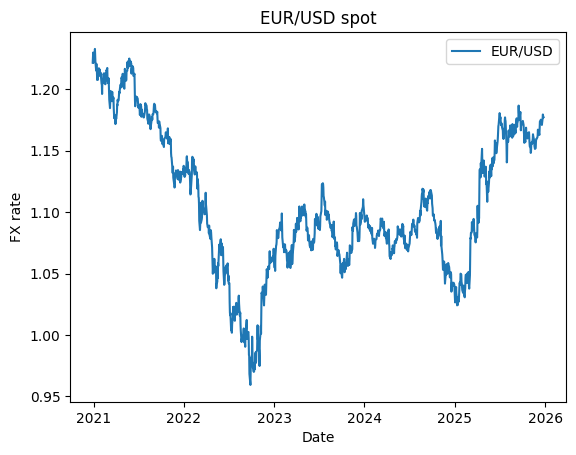

In [33]:
plt.plot(df_eurusd["Datetime"], df_eurusd["close"], label="EUR/USD")
plt.title("EUR/USD spot")
plt.xlabel("Date")
plt.ylabel("FX rate")
plt.legend()
plt.show()
